In [1]:
# Cell 1: 导入依赖和环境设置
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

print("🚀 Kaggle多模型集成深度伪造检测")
print(f"PyTorch版本: {torch.__version__}")


🚀 Kaggle多模型集成深度伪造检测
PyTorch版本: 2.6.0+cu124


In [2]:
# Cell 2: 参数配置
# Kaggle环境路径
BASE_PATH = '/kaggle/input/deepfake-and-real-images/Dataset'
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')
VAL_PATH = os.path.join(BASE_PATH, 'Validation')

# 训练参数
# 图像大小
IMG_SIZE = 256

# 训练批次大小
BATCH_SIZE = 32

# 学习率
LEARNING_RATE = 1e-4

# 训练轮数
EPOCHS = 15

# 权重衰减系数
WEIGHT_DECAY = 1e-4

# 早停轮数
PATIENCE = 3

# 多GPU设置
NUM_GPUS = torch.cuda.device_count()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {DEVICE}")
if torch.cuda.is_available():
    if NUM_GPUS > 1:
        print(f"使用多GPU训练: {[torch.cuda.get_device_name(i) for i in range(NUM_GPUS)]}")
        print(f"GPU数量: {NUM_GPUS}")
        NUM_WORKERS = 4  # 多GPU时增加数据加载线程
    else:
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        NUM_WORKERS = 0  # 单GPU时避免多进程问题
    
    for i in range(NUM_GPUS):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"GPU {i} 内存: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.1f}GB")
else:
    NUM_WORKERS = 0
    print("使用CPU训练")


使用设备: cuda
使用多GPU训练: ['Tesla T4', 'Tesla T4']
GPU数量: 2
GPU 0: Tesla T4
GPU 0 内存: 14.7GB
GPU 1: Tesla T4
GPU 1 内存: 14.7GB


In [3]:
# Cell 3: 数据加载函数
classes = ['Real', 'Fake']

def create_dataframe(data_path, dataset_type):
    """创建数据集DataFrame"""
    filepaths, labels = [], []
    
    for label_idx, cls in enumerate(classes):
        folder = os.path.join(data_path, cls)
        if os.path.exists(folder):
            for img_name in os.listdir(folder):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    filepaths.append(os.path.join(folder, img_name))
                    labels.append(label_idx)
    
    df = pd.DataFrame({'filepath': filepaths, 'label': labels})
    print(f"{dataset_type}集图片数: {len(df)}")
    if len(df) > 0:
        print(f"{dataset_type}集类别分布:")
        for idx, cls in enumerate(classes):
            count = len(df[df['label'] == idx])
            print(f"  {cls}: {count} ({count/len(df)*100:.1f}%)")
    return df

In [4]:
# Cell 4: 数据预处理和增强
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class DeepfakeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['filepath']
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(img)
        
        label = self.df.iloc[idx]['label']
        return img, label

In [5]:
# Cell 5: 模型定义
def create_efficientnet_b0():
    """创建EfficientNet-B0模型"""
    model = models.efficientnet_b0(weights='IMAGENET1K_V1')
    model.classifier[1] = nn.Linear(1280, 2)
    return model

def create_resnet18():
    """创建ResNet18模型"""
    model = models.resnet18(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(512, 2)
    return model

def create_convnext_tiny():
    """创建ConvNeXt-Tiny模型"""
    model = models.convnext_tiny(weights='IMAGENET1K_V1')
    model.classifier[2] = nn.Linear(768, 2)
    return model

# 模型配置字典
MODEL_CONFIGS = {
    'efficientnet_b0': {
        'create_fn': create_efficientnet_b0,
        'name': 'EfficientNet-B0'
    },
    'resnet18': {
        'create_fn': create_resnet18,
        'name': 'ResNet18'
    },
    'convnext_tiny': {
        'create_fn': create_convnext_tiny,
        'name': 'ConvNeXt-Tiny'
    }
}

In [6]:
# Cell 6: 单模型训练函数
def train_single_model(model_key, train_loader, val_loader, save_path):
    """训练单个模型"""
    print(f"\n🔥 开始训练 {MODEL_CONFIGS[model_key]['name']}")
    
    # 创建模型
    model = MODEL_CONFIGS[model_key]['create_fn']()
    model = model.to(DEVICE)
    
    # 多GPU支持
    if NUM_GPUS > 1:
        model = nn.DataParallel(model)
        print(f"✅ 模型已配置为多GPU训练，使用 {NUM_GPUS} 个GPU")
    
    # 损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    # 训练记录
    best_val_acc = 0
    patience_counter = 0
    train_losses, val_losses, val_accuracies = [], [], []
    
    for epoch in range(EPOCHS):
        # 训练阶段
        model.train()
        train_loss = 0
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # 验证阶段
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, LR: {current_lr:.6f}")
        
        # 保存最佳模型
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # 保存模型时处理多GPU情况
            if NUM_GPUS > 1:
                torch.save(model.module.state_dict(), save_path)
            else:
                torch.save(model.state_dict(), save_path)
            print(f"✅ 最佳模型已保存，验证准确率: {best_val_acc:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("⛔ Early stopping triggered")
                break
    
    return best_val_acc, train_losses, val_losses, val_accuracies


In [7]:
# Cell 7: 集成预测函数
def load_trained_models(model_paths):
    """加载训练好的模型"""
    models_dict = {}
    for model_key, path in model_paths.items():
        if os.path.exists(path):
            model = MODEL_CONFIGS[model_key]['create_fn']()
            model.load_state_dict(torch.load(path, map_location=DEVICE))
            model = model.to(DEVICE)
            
            # 多GPU支持
            if NUM_GPUS > 1:
                model = nn.DataParallel(model)
                print(f"✅ 已加载 {MODEL_CONFIGS[model_key]['name']} (多GPU模式)")
            else:
                print(f"✅ 已加载 {MODEL_CONFIGS[model_key]['name']}")
            
            model.eval()
            models_dict[model_key] = model
        else:
            print(f"❌ 模型文件不存在: {path}")
    return models_dict

def ensemble_predict(models_dict, data_loader, voting_type='soft', weights=None):
    """集成预测"""
    all_predictions = []
    all_labels = []
    model_outputs = {key: [] for key in models_dict.keys()}
    
    # 如果是加权投票但没有提供权重，则使用等权重
    if voting_type == 'weighted' and weights is None:
        weights = {key: 1.0 for key in models_dict.keys()}
    
    with torch.no_grad():
        for imgs, labels in tqdm(data_loader, desc="集成预测"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            
            # 收集每个模型的预测
            batch_predictions = []
            for model_key, model in models_dict.items():
                outputs = model(imgs)
                if voting_type in ['soft', 'weighted']:
                    probs = torch.softmax(outputs, dim=1)
                    batch_predictions.append(probs.cpu().numpy())
                else:  # hard voting
                    _, predicted = torch.max(outputs, 1)
                    batch_predictions.append(predicted.cpu().numpy())
                
                model_outputs[model_key].extend(outputs.cpu().numpy())
            
            # 集成预测
            if voting_type == 'soft':
                # 软投票：平均概率
                ensemble_probs = np.mean(batch_predictions, axis=0)
                ensemble_pred = np.argmax(ensemble_probs, axis=1)
            elif voting_type == 'weighted':
                # 加权投票：根据权重加权平均概率
                weighted_probs = np.zeros_like(batch_predictions[0])
                total_weight = 0
                for i, (model_key, probs) in enumerate(zip(models_dict.keys(), batch_predictions)):
                    weight = weights[model_key]
                    weighted_probs += probs * weight
                    total_weight += weight
                ensemble_probs = weighted_probs / total_weight
                ensemble_pred = np.argmax(ensemble_probs, axis=1)
            else:
                # 硬投票：多数投票
                batch_predictions = np.array(batch_predictions)
                ensemble_pred = []
                for i in range(batch_predictions.shape[1]):
                    votes = batch_predictions[:, i]
                    ensemble_pred.append(np.bincount(votes).argmax())
                ensemble_pred = np.array(ensemble_pred)
            
            all_predictions.extend(ensemble_pred)
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels), model_outputs

def calculate_model_weights(model_results, weight_method='accuracy'):
    """计算模型权重"""
    weights = {}
    
    if weight_method == 'accuracy':
        # 基于验证准确率计算权重
        accuracies = {key: results['best_acc'] for key, results in model_results.items()}
        total_acc = sum(accuracies.values())
        
        for key, acc in accuracies.items():
            weights[key] = acc / total_acc
            
    elif weight_method == 'softmax':
        # 使用softmax归一化准确率作为权重
        accuracies = np.array([results['best_acc'] for results in model_results.values()])
        softmax_weights = np.exp(accuracies * 10) / np.sum(np.exp(accuracies * 10))  # 乘以10增强差异
        
        for i, key in enumerate(model_results.keys()):
            weights[key] = softmax_weights[i]
            
    elif weight_method == 'rank':
        # 基于排名的权重分配
        sorted_models = sorted(model_results.items(), key=lambda x: x[1]['best_acc'], reverse=True)
        n_models = len(sorted_models)
        
        for i, (key, _) in enumerate(sorted_models):
            weights[key] = (n_models - i) / sum(range(1, n_models + 1))
    
    return weights

In [8]:
# Cell 8: 加载数据
print("📂 加载数据集...")
train_df = create_dataframe(TRAIN_PATH, "训练")
val_df = create_dataframe(VAL_PATH, "验证")

# 限制验证集大小为6400以减少内存使用
MAX_VAL_SAMPLES = 6400
if len(val_df) > MAX_VAL_SAMPLES:
    print(f"⚠️ 验证集过大 ({len(val_df)} 张)，随机采样 {MAX_VAL_SAMPLES} 张图片")
    # 保持类别平衡的随机采样
    val_df = val_df.groupby('label', group_keys=False).apply(
        lambda x: x.sample(min(len(x), MAX_VAL_SAMPLES//2), random_state=42)
    ).reset_index(drop=True)
    print(f"✅ 验证集采样完成，当前大小: {len(val_df)}")
    print(f"验证集类别分布:")
    for idx, cls in enumerate(classes):
        count = len(val_df[val_df['label'] == idx])
        print(f"  {cls}: {count} ({count/len(val_df)*100:.1f}%)")

print(f"\n📊 数据集总览:")
print(f"训练集总数: {len(train_df)}")
print(f"验证集总数: {len(val_df)}")
print(f"验证批次数: {len(val_df) // BATCH_SIZE + (1 if len(val_df) % BATCH_SIZE > 0 else 0)}")

# 创建数据集和数据加载器
train_dataset = DeepfakeDataset(train_df, transform=train_transform)
val_dataset = DeepfakeDataset(val_df, transform=val_transform)

# 使用动态配置的num_workers和pin_memory
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


📂 加载数据集...
训练集图片数: 140002
训练集类别分布:
  Real: 70001 (50.0%)
  Fake: 70001 (50.0%)
验证集图片数: 39428
验证集类别分布:
  Real: 19787 (50.2%)
  Fake: 19641 (49.8%)
⚠️ 验证集过大 (39428 张)，随机采样 6400 张图片
✅ 验证集采样完成，当前大小: 6400
验证集类别分布:
  Real: 3200 (50.0%)
  Fake: 3200 (50.0%)

📊 数据集总览:
训练集总数: 140002
验证集总数: 6400
验证批次数: 200


In [9]:
# Cell 9: 训练所有模型
print("\n🚀 开始训练多个模型...")

# 选择要训练的模型（可以根据需要调整）
selected_models = ['efficientnet_b0', 'resnet18', 'convnext_tiny']  # 减少模型数量以适应Kaggle环境
model_paths = {}
model_results = {}

for model_key in selected_models:
    save_path = f"best_{model_key}_model.pth"
    model_paths[model_key] = save_path
    
    best_acc, train_losses, val_losses, val_accs = train_single_model(
        model_key, train_loader, val_loader, save_path
    )
    
    model_results[model_key] = {
        'best_acc': best_acc,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accs
    }
    
    print(f"✅ {MODEL_CONFIGS[model_key]['name']} 训练完成，最佳验证准确率: {best_acc:.4f}")



🚀 开始训练多个模型...

🔥 开始训练 EfficientNet-B0


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 147MB/s]


✅ 模型已配置为多GPU训练，使用 2 个GPU


Epoch 1/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.0853, Val Loss: 0.0597, Val Acc: 0.9761, LR: 0.000100
✅ 最佳模型已保存，验证准确率: 0.9761


Epoch 2/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.0446, Val Loss: 0.0583, Val Acc: 0.9758, LR: 0.000100


Epoch 3/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.0374, Val Loss: 0.0612, Val Acc: 0.9795, LR: 0.000100
✅ 最佳模型已保存，验证准确率: 0.9795


Epoch 4/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.0350, Val Loss: 0.0468, Val Acc: 0.9830, LR: 0.000100
✅ 最佳模型已保存，验证准确率: 0.9830


Epoch 5/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.0318, Val Loss: 0.0551, Val Acc: 0.9794, LR: 0.000100


Epoch 6/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.0317, Val Loss: 0.0547, Val Acc: 0.9800, LR: 0.000100


Epoch 7/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.0307, Val Loss: 0.0422, Val Acc: 0.9845, LR: 0.000100
✅ 最佳模型已保存，验证准确率: 0.9845


Epoch 8/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.0294, Val Loss: 0.0447, Val Acc: 0.9844, LR: 0.000100


Epoch 9/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.0294, Val Loss: 0.1091, Val Acc: 0.9642, LR: 0.000100


Epoch 10/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.0289, Val Loss: 0.0579, Val Acc: 0.9791, LR: 0.000100
⛔ Early stopping triggered
✅ EfficientNet-B0 训练完成，最佳验证准确率: 0.9845

🔥 开始训练 ResNet18


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 155MB/s]

✅ 模型已配置为多GPU训练，使用 2 个GPU


Epoch 1/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.0840, Val Loss: 0.0761, Val Acc: 0.9669, LR: 0.000100
✅ 最佳模型已保存，验证准确率: 0.9669


Epoch 2/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.0509, Val Loss: 0.0720, Val Acc: 0.9728, LR: 0.000100
✅ 最佳模型已保存，验证准确率: 0.9728


Epoch 3/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.0449, Val Loss: 0.0637, Val Acc: 0.9769, LR: 0.000100
✅ 最佳模型已保存，验证准确率: 0.9769


Epoch 4/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.0415, Val Loss: 0.0960, Val Acc: 0.9688, LR: 0.000100


Epoch 5/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.0383, Val Loss: 0.0516, Val Acc: 0.9814, LR: 0.000100
✅ 最佳模型已保存，验证准确率: 0.9814


Epoch 6/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.0361, Val Loss: 0.0518, Val Acc: 0.9783, LR: 0.000100


Epoch 7/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.0351, Val Loss: 0.0473, Val Acc: 0.9819, LR: 0.000100
✅ 最佳模型已保存，验证准确率: 0.9819


Epoch 8/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.0335, Val Loss: 0.0584, Val Acc: 0.9764, LR: 0.000100


Epoch 9/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.0329, Val Loss: 0.0671, Val Acc: 0.9758, LR: 0.000100


Epoch 10/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.0318, Val Loss: 0.0586, Val Acc: 0.9780, LR: 0.000100
⛔ Early stopping triggered
✅ ResNet18 训练完成，最佳验证准确率: 0.9819

🔥 开始训练 ConvNeXt-Tiny


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 214MB/s]


✅ 模型已配置为多GPU训练，使用 2 个GPU


Epoch 1/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.0678, Val Loss: 0.0885, Val Acc: 0.9652, LR: 0.000100
✅ 最佳模型已保存，验证准确率: 0.9652


Epoch 2/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.0461, Val Loss: 0.0643, Val Acc: 0.9766, LR: 0.000100
✅ 最佳模型已保存，验证准确率: 0.9766


Epoch 3/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.0434, Val Loss: 0.1061, Val Acc: 0.9609, LR: 0.000100


Epoch 4/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.0409, Val Loss: 0.0547, Val Acc: 0.9778, LR: 0.000100
✅ 最佳模型已保存，验证准确率: 0.9778


Epoch 5/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.0391, Val Loss: 0.0538, Val Acc: 0.9781, LR: 0.000100
✅ 最佳模型已保存，验证准确率: 0.9781


Epoch 6/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.0370, Val Loss: 0.1013, Val Acc: 0.9705, LR: 0.000100


Epoch 7/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.0361, Val Loss: 0.0478, Val Acc: 0.9808, LR: 0.000100
✅ 最佳模型已保存，验证准确率: 0.9808


Epoch 8/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.0347, Val Loss: 0.0642, Val Acc: 0.9784, LR: 0.000100


Epoch 9/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.0334, Val Loss: 0.0535, Val Acc: 0.9806, LR: 0.000100


Epoch 10/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.0333, Val Loss: 0.0913, Val Acc: 0.9680, LR: 0.000100
⛔ Early stopping triggered
✅ ConvNeXt-Tiny 训练完成，最佳验证准确率: 0.9808


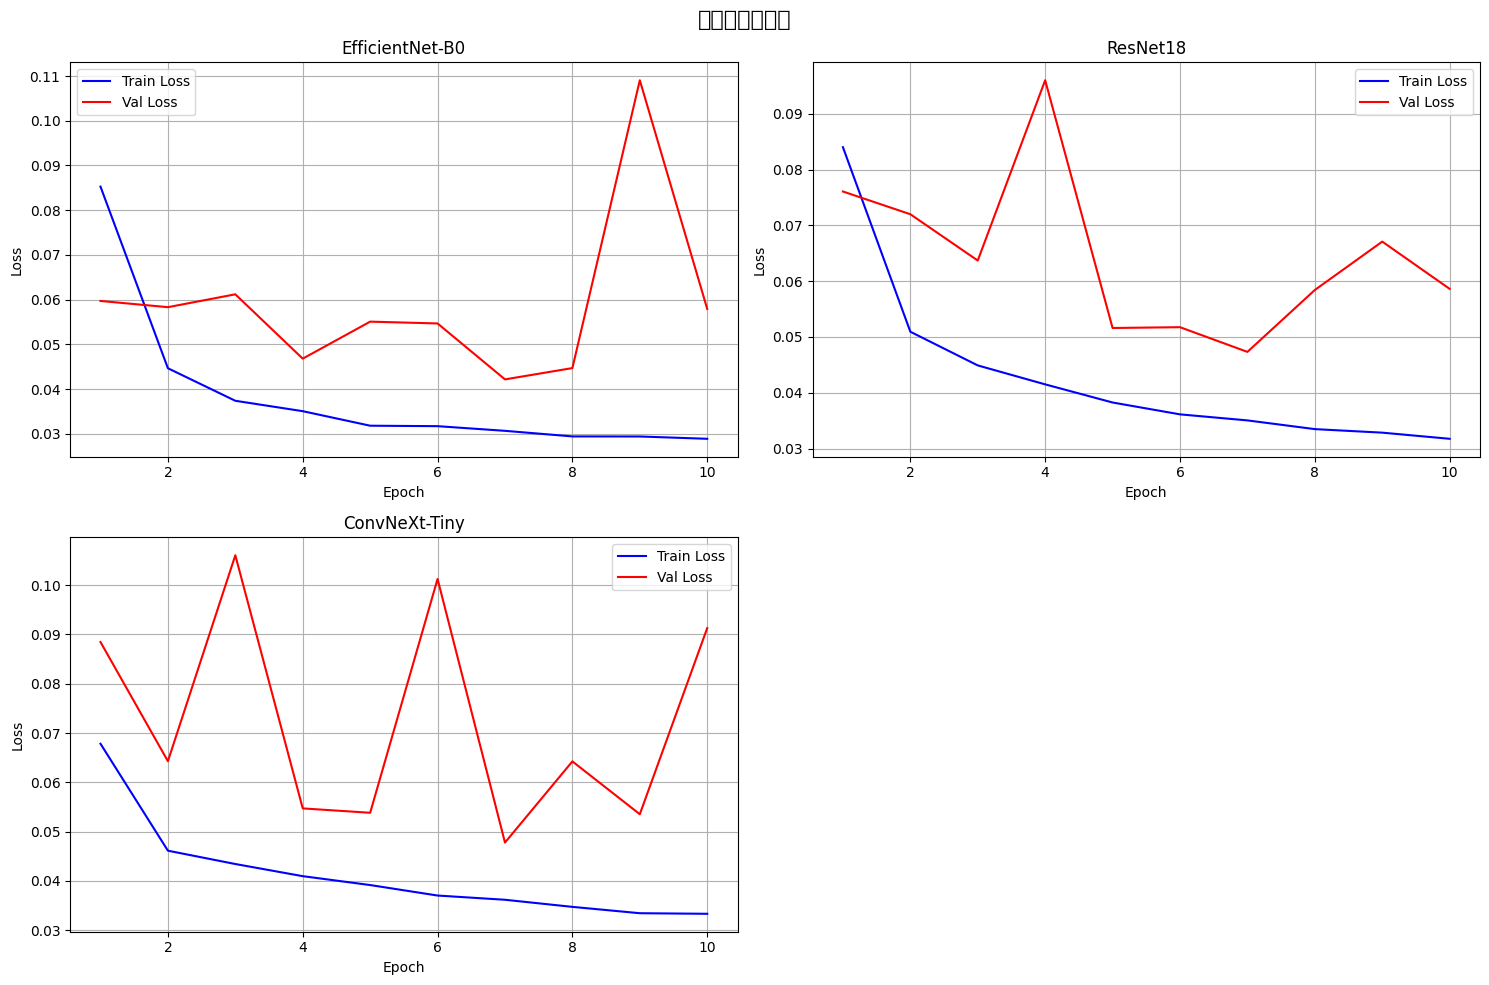

In [10]:
# Cell 10: 可视化训练过程
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('多模型训练过程', fontsize=16)

for idx, (model_key, results) in enumerate(model_results.items()):
    row = idx // 2
    col = idx % 2
    
    ax = axes[row, col]
    epochs = range(1, len(results['train_losses']) + 1)
    
    ax.plot(epochs, results['train_losses'], 'b-', label='Train Loss')
    ax.plot(epochs, results['val_losses'], 'r-', label='Val Loss')
    ax.set_title(f"{MODEL_CONFIGS[model_key]['name']}")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

# 如果模型数量少于4个，隐藏多余的子图
for idx in range(len(model_results), 4):
    row = idx // 2
    col = idx % 2
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()


In [11]:
# Cell 11: 集成预测和评估
print("\n🔮 开始集成预测...")

# 加载训练好的模型
trained_models = load_trained_models(model_paths)

# 计算模型权重
print("\n⚖️ 计算模型权重...")
model_weights = calculate_model_weights(model_results, weight_method='accuracy')
print("模型权重分配:")
for model_key, weight in model_weights.items():
    print(f"  {MODEL_CONFIGS[model_key]['name']:15}: {weight:.4f}")

# 软投票预测
print("\n📊 软投票集成预测:")
soft_predictions, true_labels, _ = ensemble_predict(trained_models, val_loader, voting_type='soft')
soft_accuracy = accuracy_score(true_labels, soft_predictions)
print(f"软投票准确率: {soft_accuracy:.4f}")

# 硬投票预测
print("\n📊 硬投票集成预测:")
hard_predictions, _, _ = ensemble_predict(trained_models, val_loader, voting_type='hard')
hard_accuracy = accuracy_score(true_labels, hard_predictions)
print(f"硬投票准确率: {hard_accuracy:.4f}")

# 加权投票预测
print("\n📊 加权投票集成预测:")
weighted_predictions, _, _ = ensemble_predict(trained_models, val_loader, voting_type='weighted', weights=model_weights)
weighted_accuracy = accuracy_score(true_labels, weighted_predictions)
print(f"加权投票准确率: {weighted_accuracy:.4f}")



🔮 开始集成预测...
✅ 已加载 EfficientNet-B0 (多GPU模式)
✅ 已加载 ResNet18 (多GPU模式)
✅ 已加载 ConvNeXt-Tiny (多GPU模式)

⚖️ 计算模型权重...
模型权重分配:
  EfficientNet-B0: 0.3341
  ResNet18       : 0.3332
  ConvNeXt-Tiny  : 0.3328

📊 软投票集成预测:


集成预测:   0%|          | 0/200 [00:00<?, ?it/s]

软投票准确率: 0.9869

📊 硬投票集成预测:


集成预测:   0%|          | 0/200 [00:00<?, ?it/s]

硬投票准确率: 0.9872

📊 加权投票集成预测:


集成预测:   0%|          | 0/200 [00:00<?, ?it/s]

加权投票准确率: 0.9869



📈 模型性能对比:
EfficientNet-B0: 0.9845
ResNet18       : 0.9819
ConvNeXt-Tiny  : 0.9808
软投票集成          : 0.9869
硬投票集成          : 0.9872
加权投票集成         : 0.9869


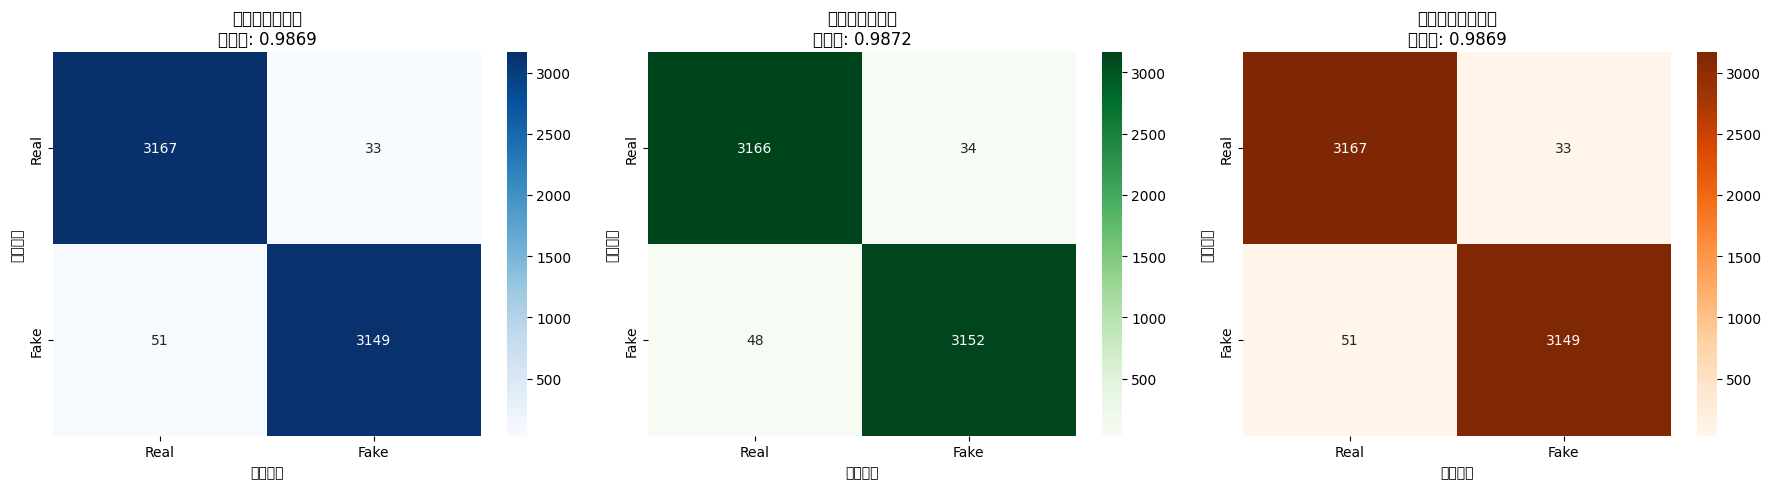

In [12]:
# Cell 12: 结果对比和可视化
# 单模型结果对比
print("\n📈 模型性能对比:")
print("="*50)
for model_key in selected_models:
    best_acc = model_results[model_key]['best_acc']
    print(f"{MODEL_CONFIGS[model_key]['name']:15}: {best_acc:.4f}")

print(f"{'软投票集成':15}: {soft_accuracy:.4f}")
print(f"{'硬投票集成':15}: {hard_accuracy:.4f}")
print(f"{'加权投票集成':15}: {weighted_accuracy:.4f}")

# 混淆矩阵可视化
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 软投票混淆矩阵
cm_soft = confusion_matrix(true_labels, soft_predictions)
sns.heatmap(cm_soft, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes, ax=axes[0])
axes[0].set_title(f"软投票混淆矩阵\n准确率: {soft_accuracy:.4f}")
axes[0].set_ylabel("真实标签")
axes[0].set_xlabel("预测标签")

# 硬投票混淆矩阵
cm_hard = confusion_matrix(true_labels, hard_predictions)
sns.heatmap(cm_hard, annot=True, fmt="d", cmap="Greens", 
            xticklabels=classes, yticklabels=classes, ax=axes[1])
axes[1].set_title(f"硬投票混淆矩阵\n准确率: {hard_accuracy:.4f}")
axes[1].set_ylabel("真实标签")
axes[1].set_xlabel("预测标签")

# 加权投票混淆矩阵
cm_weighted = confusion_matrix(true_labels, weighted_predictions)
sns.heatmap(cm_weighted, annot=True, fmt="d", cmap="Oranges", 
            xticklabels=classes, yticklabels=classes, ax=axes[2])
axes[2].set_title(f"加权投票混淆矩阵\n准确率: {weighted_accuracy:.4f}")
axes[2].set_ylabel("真实标签")
axes[2].set_xlabel("预测标签")

plt.tight_layout()
plt.show()

In [13]:
# Cell 13: 详细分类报告
print("\n📋 软投票详细分类报告:")
print("="*50)
print(classification_report(true_labels, soft_predictions, target_names=classes))

print("\n📋 硬投票详细分类报告:")
print("="*50)
print(classification_report(true_labels, hard_predictions, target_names=classes))

print("\n📋 加权投票详细分类报告:")
print("="*50)
print(classification_report(true_labels, weighted_predictions, target_names=classes))



📋 软投票详细分类报告:
              precision    recall  f1-score   support

        Real       0.98      0.99      0.99      3200
        Fake       0.99      0.98      0.99      3200

    accuracy                           0.99      6400
   macro avg       0.99      0.99      0.99      6400
weighted avg       0.99      0.99      0.99      6400


📋 硬投票详细分类报告:
              precision    recall  f1-score   support

        Real       0.99      0.99      0.99      3200
        Fake       0.99      0.98      0.99      3200

    accuracy                           0.99      6400
   macro avg       0.99      0.99      0.99      6400
weighted avg       0.99      0.99      0.99      6400


📋 加权投票详细分类报告:
              precision    recall  f1-score   support

        Real       0.98      0.99      0.99      3200
        Fake       0.99      0.98      0.99      3200

    accuracy                           0.99      6400
   macro avg       0.99      0.99      0.99      6400
weighted avg       0.99      0.

In [14]:
# Cell 14: 最终总结
print("\n" + "="*60)
print("🎉 多模型集成训练完成！")
print("="*60)
print(f"训练的模型数量: {len(selected_models)}")
print(f"最佳单模型准确率: {max([results['best_acc'] for results in model_results.values()]):.4f}")
print(f"软投票集成准确率: {soft_accuracy:.4f}")
print(f"硬投票集成准确率: {hard_accuracy:.4f}")
print(f"加权投票集成准确率: {weighted_accuracy:.4f}")

# 计算提升幅度
best_single = max([results['best_acc'] for results in model_results.values()])
soft_improvement = (soft_accuracy - best_single) * 100
hard_improvement = (hard_accuracy - best_single) * 100
weighted_improvement = (weighted_accuracy - best_single) * 100

print(f"软投票相对提升: {soft_improvement:+.2f}%")
print(f"硬投票相对提升: {hard_improvement:+.2f}%")
print(f"加权投票相对提升: {weighted_improvement:+.2f}%")

# 找出最佳集成方法
ensemble_results = {
    '软投票': soft_accuracy,
    '硬投票': hard_accuracy,
    '加权投票': weighted_accuracy
}
best_ensemble = max(ensemble_results, key=ensemble_results.get)
print(f"\n🏆 最佳集成方法: {best_ensemble} (准确率: {ensemble_results[best_ensemble]:.4f})")

print(f"\n💾 保存的模型文件:")
for model_key, path in model_paths.items():
    print(f"  {MODEL_CONFIGS[model_key]['name']}: {path}")

print(f"\n⚖️ 模型权重分配:")
for model_key, weight in model_weights.items():
    print(f"  {MODEL_CONFIGS[model_key]['name']}: {weight:.4f}")


🎉 多模型集成训练完成！
训练的模型数量: 3
最佳单模型准确率: 0.9845
软投票集成准确率: 0.9869
硬投票集成准确率: 0.9872
加权投票集成准确率: 0.9869
软投票相对提升: +0.23%
硬投票相对提升: +0.27%
加权投票相对提升: +0.23%

🏆 最佳集成方法: 硬投票 (准确率: 0.9872)

💾 保存的模型文件:
  EfficientNet-B0: best_efficientnet_b0_model.pth
  ResNet18: best_resnet18_model.pth
  ConvNeXt-Tiny: best_convnext_tiny_model.pth

⚖️ 模型权重分配:
  EfficientNet-B0: 0.3341
  ResNet18: 0.3332
  ConvNeXt-Tiny: 0.3328
